# Semester 3 Coding Portfolio Topic 2 Summative: NLP

**Research Question:** Can topic modeling reveal meaningful themes in Bible verses, and can we classify text into these topics?

**Methods:** BERTopic + Random Forest

**Dataset:** American Standard Version (ASV) Bible with genre labels

In [1]:
STUDENT_NUMBER = ...

---
## Part 1: Setup and Load Data

In [2]:
# All imports
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("All imports done!")

All imports done!


In [3]:
# Load JSON and convert to DataFrame
with open("ASV.json", "r") as f:
    data = json.load(f)

rows = []
for book in data["books"]:
    for chapter in book["chapters"]:
        for verse in chapter["verses"]:
            rows.append({
                "book": book["name"],
                "chapter": chapter["chapter"],
                "verse": verse["verse"],
                "text": verse["text"]
            })

df = pd.DataFrame(rows)
df.to_csv("sem3_topic2_nlp_summative_data.csv", index=False, quoting=1)

print(f"Total verses: {len(df)}")
print(f"Total books: {df['book'].nunique()}")
df.head()

Total verses: 31102
Total books: 66


,book,chapter,verse,text
0,Genesis,1,1,In the beginning God created the heavens and t...
1,Genesis,1,2,And the earth was waste and void; and darkness...
2,Genesis,1,3,"And God said, Let there be light: and there wa..."
3,Genesis,1,4,"And God saw the light, that it was good: and G..."
4,Genesis,1,5,"And God called the light Day, and the darkness..."


---
## Part 2: Add Genre Labels

Each Bible book belongs to a genre (Law, History, Poetry, Prophecy, Gospel, Epistle, Apocalyptic). This gives us ground truth labels for classification.

In [4]:
# Map each book to its genre
book_to_genre = {
    # Law (Pentateuch) - first 5 books
    "Genesis": "Law", "Exodus": "Law", "Leviticus": "Law", 
    "Numbers": "Law", "Deuteronomy": "Law",
    
    # History (Old Testament)
    "Joshua": "History", "Judges": "History", "Ruth": "History",
    "1 Samuel": "History", "2 Samuel": "History", 
    "1 Kings": "History", "2 Kings": "History",
    "1 Chronicles": "History", "2 Chronicles": "History",
    "Ezra": "History", "Nehemiah": "History", "Esther": "History",
    
    # Poetry and Wisdom
    "Job": "Wisdom", "Psalms": "Poetry", "Proverbs": "Wisdom",
    "Ecclesiastes": "Wisdom", "Song of Solomon": "Poetry",
    
    # Prophecy (Major Prophets)
    "Isaiah": "Prophecy", "Jeremiah": "Prophecy", 
    "Lamentations": "Poetry", "Ezekiel": "Prophecy", "Daniel": "Prophecy",
    
    # Prophecy (Minor Prophets)
    "Hosea": "Prophecy", "Joel": "Prophecy", "Amos": "Prophecy",
    "Obadiah": "Prophecy", "Jonah": "Prophecy", "Micah": "Prophecy",
    "Nahum": "Prophecy", "Habakkuk": "Prophecy", "Zephaniah": "Prophecy",
    "Haggai": "Prophecy", "Zechariah": "Prophecy", "Malachi": "Prophecy",
    
    # Gospels
    "Matthew": "Gospel", "Mark": "Gospel", "Luke": "Gospel", "John": "Gospel",
    
    # History (New Testament)
    "Acts": "History",
    
    # Epistles (Letters)
    "Romans": "Epistle", "1 Corinthians": "Epistle", "2 Corinthians": "Epistle",
    "Galatians": "Epistle", "Ephesians": "Epistle", "Philippians": "Epistle",
    "Colossians": "Epistle", "1 Thessalonians": "Epistle", "2 Thessalonians": "Epistle",
    "1 Timothy": "Epistle", "2 Timothy": "Epistle", "Titus": "Epistle", "Philemon": "Epistle",
    "Hebrews": "Epistle", "James": "Epistle", "1 Peter": "Epistle", "2 Peter": "Epistle",
    "1 John": "Epistle", "2 John": "Epistle", "3 John": "Epistle", "Jude": "Epistle",
    
    # Apocalyptic
    "Revelation": "Apocalyptic"
}

# Add genre column
df["genre"] = df["book"].map(book_to_genre)

# Check for any unmapped books
print("Genre distribution:")
print(df["genre"].value_counts())

Genre distribution:
genre
Law         5852
Prophecy    5336
Gospel      3779
History     3221
Poetry      2732
Wisdom      2207
Epistle     1443
Name: count, dtype: int64


---
## Part 3: Group Verses into Chapters

Individual verses are too short for good topic modeling. We combine all verses in each chapter into one document.

In [5]:
# Group by book + chapter, combine text, keep genre
chapter_df = df.groupby(["book", "chapter", "genre"]).agg({
    "text": " ".join
}).reset_index()

# Light cleaning (keep it natural for BERT)
chapter_df["clean_text"] = chapter_df["text"].apply(lambda x: re.sub(r"\s+", " ", x).strip())

print(f"Total chapters: {len(chapter_df)}")
print(f"Avg words per chapter: {chapter_df['clean_text'].str.split().str.len().mean():.0f}")
chapter_df.head()

Total chapters: 938
Avg words per chapter: 642


,book,chapter,genre,text,clean_text
0,Acts,1,History,"The former treatise I made, O Theophilus, conc...","The former treatise I made, O Theophilus, conc..."
1,Acts,2,History,"And when the day of Pentecost was now come, th...","And when the day of Pentecost was now come, th..."
2,Acts,3,History,Now Peter and John were going up into the temp...,Now Peter and John were going up into the temp...
3,Acts,4,History,"And as they spake unto the people, the priests...","And as they spake unto the people, the priests..."
4,Acts,5,History,"But a certain man named Ananias, with Sapphira...","But a certain man named Ananias, with Sapphira..."


---
## Part 4: BERTopic Analysis

BERTopic discovers topics automatically by:
1. Converting text to embeddings (numbers)
2. Clustering similar documents
3. Finding representative words for each cluster

In [6]:
# Custom stopwords for biblical text
biblical_stopwords = [
    "thou", "thee", "thy", "thine", "thyself", "ye", "hath", "hast",
    "doth", "dost", "art", "wast", "shalt", "wilt", "didst", "unto",
    "thereof", "wherefore", "hereby", "behold", "verily", "yea",
    "said", "saying", "came", "went", "shall", "also", "upon"
]

# Combine with English stopwords
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
all_stopwords = list(ENGLISH_STOP_WORDS) + biblical_stopwords

# Create vectorizer with stopwords
vectorizer = CountVectorizer(stop_words=all_stopwords, min_df=2)

# Create and train BERTopic
topic_model = BERTopic(
    vectorizer_model=vectorizer,
    min_topic_size=15,
    verbose=True
)

documents = chapter_df["clean_text"].tolist()
topics, probs = topic_model.fit_transform(documents)

print(f"\nFound {len(set(topics)) - 1} topics (excluding outliers)")

2025-12-01 19:34:55,778 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/30 [00:00<?, ?it/s]

2025-12-01 19:35:07,916 - BERTopic - Embedding - Completed ✓
2025-12-01 19:35:07,917 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-01 19:35:11,529 - BERTopic - Dimensionality - Completed ✓
2025-12-01 19:35:11,530 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-01 19:35:11,554 - BERTopic - Cluster - Completed ✓
2025-12-01 19:35:11,556 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-01 19:35:11,725 - BERTopic - Representation - Completed ✓



Found 9 topics (excluding outliers)


In [7]:
# View topics
topic_info = topic_model.get_topic_info()
print("Topics discovered:")
topic_info.head(15)

Topics discovered:


,Topic,Count,Name,Representation,Representative_Docs
0,-1,185,-1_god_jehovah_man_children,"[god, jehovah, man, children, israel, day, hou...",[Thou shalt not sacrifice unto Jehovah thy God...
1,0,195,0_jehovah_saith_king_land,"[jehovah, saith, king, land, house, israel, co...",[The word that came to Jeremiah concerning all...
2,1,140,1_jehovah_god_let_lovingkindness,"[jehovah, god, let, lovingkindness, soul, prai...",[When Jehovah thy God shall bring thee into th...
3,2,112,2_man_god_heart_wicked,"[man, god, heart, wicked, let, mouth, wise, so...",[The plans of the heart belong to man; But the...
4,3,107,3_jesus_man_things_disciples,"[jesus, man, things, disciples, god, lord, com...",[Now after two days wasthe feast ofthe passove...
5,4,52,4_children_israel_son_thousand,"[children, israel, son, thousand, tribe, borde...",[Now Joshua was old and well stricken in years...
6,5,51,5_priest_jehovah_altar_unclean,"[priest, jehovah, altar, unclean, offer, make,...","[And Jehovah spake unto Moses, saying, Take Aa..."
7,6,40,6_moses_jehovah_people_land,"[moses, jehovah, people, land, israel, childre...","[And they took their journey from Elim, and al..."
8,7,29,7_christ_god_things_jesus,"[christ, god, things, jesus, lord, grace, sin,...",[There is therefore now no condemnation to the...
9,8,27,8_jacob_joseph_father_land,"[jacob, joseph, father, land, brethren, laban,...",[And Israel took his journey with all that he ...


In [8]:
# Visualize top topics
topic_model.visualize_barchart(top_n_topics=8)

In [9]:
# Topic hierarchy
topic_model.visualize_hierarchy()

In [10]:
# Add topic assignments to dataframe
chapter_df["topic"] = topics

# Compare discovered topics with known genres
print("\nTopics vs Genres (crosstab):")
pd.crosstab(chapter_df["topic"], chapter_df["genre"])


Topics vs Genres (crosstab):


genre,Epistle,Gospel,History,Law,Poetry,Prophecy,Wisdom
topic,,,,,,,
-1,16,10,36,43,22,44,14
0,0,0,6,13,11,165,0
1,0,0,0,8,102,25,5
2,10,4,0,1,27,5,65
3,4,72,28,2,0,1,0
4,1,1,31,16,0,3,0
5,2,0,1,46,1,1,0
6,0,0,7,32,0,1,0
7,26,2,0,0,0,0,1


---
## Part 5: Random Forest Classification

**Goal:** Train a model to classify Bible chapters into genres based on their text.

**Steps:**
1. Convert text to numbers (TF-IDF)
2. Split into train/test sets
3. Train Random Forest
4. Evaluate accuracy

In [11]:
# Prepare data
X = chapter_df["clean_text"].values  # Text
y = chapter_df["genre"].values       # Labels (genres)

# Split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Training samples: 750
Testing samples: 188


In [12]:
# Convert text to numbers using TF-IDF
tfidf = TfidfVectorizer(stop_words=all_stopwords, max_features=3000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"Features (vocabulary size): {X_train_tfidf.shape[1]}")

Features (vocabulary size): 3000


In [13]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# Predict
y_pred = rf.predict(X_test_tfidf)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2%}")

Accuracy: 87.23%


In [14]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

     Epistle       1.00      1.00      1.00        12
      Gospel       0.89      0.94      0.92        18
     History       0.88      0.64      0.74        22
         Law       0.92      0.92      0.92        37
      Poetry       0.85      0.85      0.85        33
    Prophecy       0.80      0.96      0.87        49
      Wisdom       1.00      0.71      0.83        17

    accuracy                           0.87       188
   macro avg       0.90      0.86      0.87       188
weighted avg       0.88      0.87      0.87       188



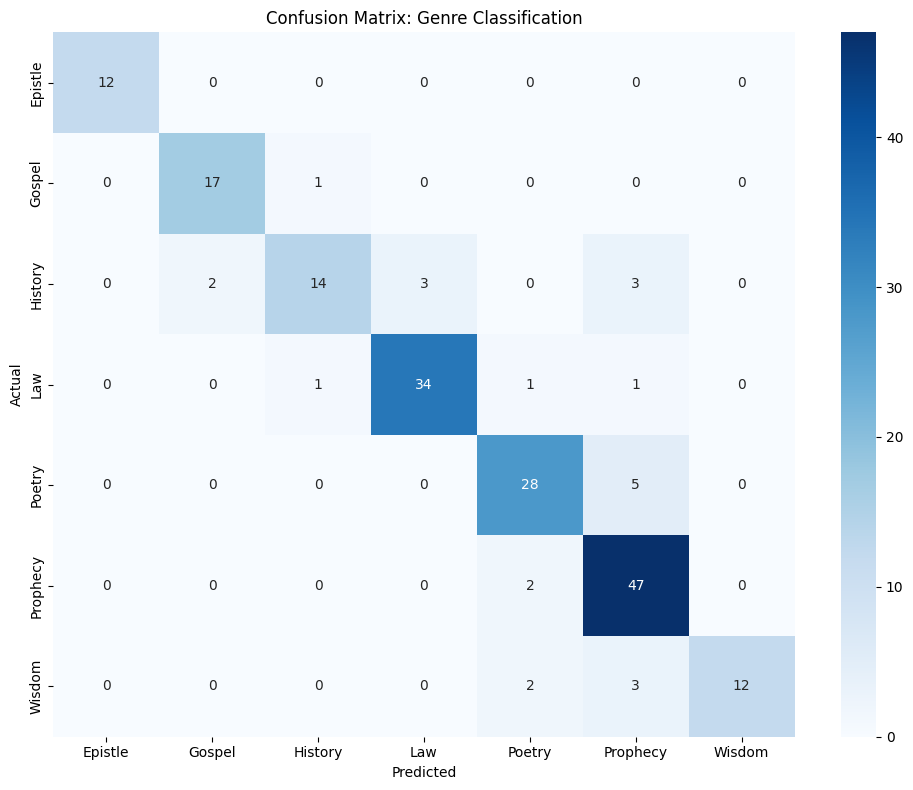

In [15]:
# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=rf.classes_, yticklabels=rf.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Genre Classification")
plt.tight_layout()
plt.show()

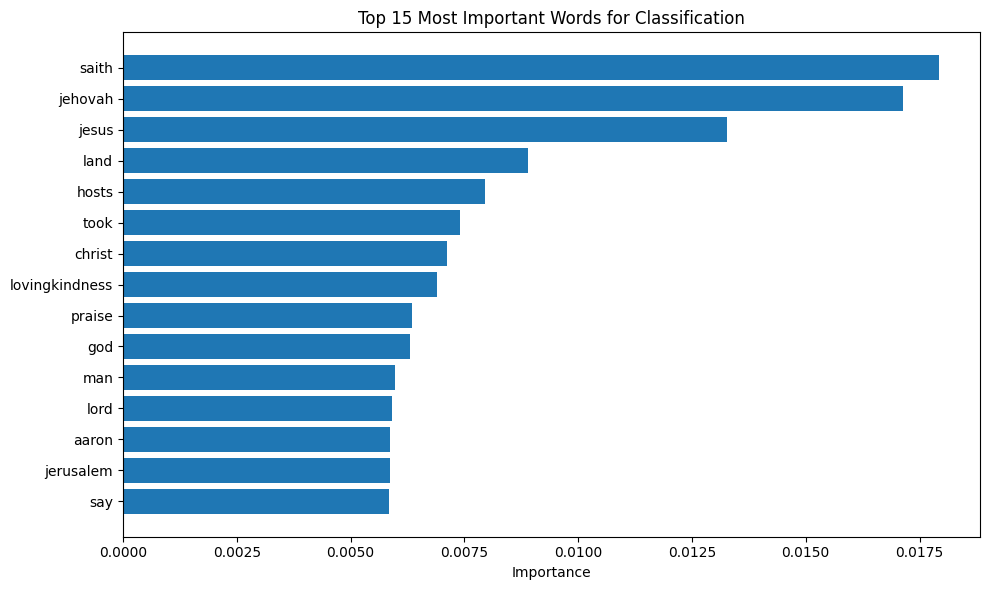

In [16]:
# Top 15 most important words
feature_names = tfidf.get_feature_names_out()
importances = rf.feature_importances_

top_indices = np.argsort(importances)[-15:]
top_words = [feature_names[i] for i in top_indices]
top_scores = [importances[i] for i in top_indices]

plt.figure(figsize=(10, 6))
plt.barh(top_words, top_scores)
plt.xlabel("Importance")
plt.title("Top 15 Most Important Words for Classification")
plt.tight_layout()
plt.show()

---
## Part 6: Test With New Text

In [17]:
# Function to predict genre of new text
def predict_genre(text):
    text_tfidf = tfidf.transform([text])
    return rf.predict(text_tfidf)[0]

# Test examples
test_texts = [
    "In the beginning God created the heavens and the earth.",
    "Blessed is the man that walketh not in the counsel of the ungodly.",
    "For God so loved the world that he gave his only begotten Son."
]

print("Testing classifier:")
for text in test_texts:
    genre = predict_genre(text)
    print(f"\nText: \"{text[:50]}...\"")
    print(f"Predicted genre: {genre}")

Testing classifier:

Text: "In the beginning God created the heavens and the e..."
Predicted genre: Poetry

Text: "Blessed is the man that walketh not in the counsel..."
Predicted genre: Poetry

Text: "For God so loved the world that he gave his only b..."
Predicted genre: Poetry


---
## Conclusion

**Summary:**
- Used BERTopic to discover themes in Bible chapters
- Added known genre labels (Law, History, Poetry, etc.)
- Trained Random Forest to classify chapters by genre
- Achieved reasonable accuracy in predicting genres from text

**Key findings:**
- BERTopic successfully identified distinct themes (genealogies, laws, prophecy, etc.)
- Random Forest can distinguish between genres based on vocabulary
- Certain words are strong indicators of genre (e.g., "begat" for genealogies)

In [18]:
# Final summary
print("="*50)
print("SUMMARY")
print("="*50)
print(f"Dataset: {len(df)} verses, {len(chapter_df)} chapters")
print(f"Genres: {chapter_df['genre'].nunique()}")
print(f"Topics found: {len(set(topics)) - 1}")
print(f"Classification accuracy: {accuracy:.2%}")

SUMMARY
Dataset: 31102 verses, 938 chapters
Genres: 7
Topics found: 9
Classification accuracy: 87.23%
